# ASME DIV5 Graphite Probability of Failure Code

In [1]:
import numpy as np
import csv
import math
import tkinter as tk
import tkinter.filedialog as fd
import matplotlib.pylab as plt
from scipy.optimize import fsolve

def simple_assess(entries,pof):
    Sc = (float(entries['Weibull characteristic strength Sc [MPa]'].get())) #Characteristic Strength
    m = (float(entries['Weibull shape factor m'].get())) #Shape Factor
    
    func = lambda x : pof - ((x/Sc)**(m-1))*(m/Sc)*np.exp(-(x/Sc)**m)
    
    x_initial_guess = 10
    x_solution = fsolve(func, x_initial_guess)
    
    return(x_solution[0])

def calculate_principal_stress(i):
    sigma = np.array([[i[0], i[3], i[4]],
                      [i[3], i[1], i[5]],
                      [i[4], i[5], i[2]]])
    # compute principal stresses
    eigvals = list(np.linalg.eigvalsh(sigma))
    eigvals.sort()
    eigvals.reverse()
    maxshear = (eigvals[0] - eigvals[2]) / 2.0
    return (eigvals[0], eigvals[1], eigvals[2], maxshear)

def remove_duplicates(values):
    output = []
    seen = set()
    for value in values:
        # If value has not been encountered yet,
        # ... add it to both list and set.
        if value not in seen:
            output.append(value)
            seen.add(value)
    return output

def solver_type(solver, filename, entries, entries2):
    if solver == 1:
        ansys(filename,entries,entries2)
    if solver == 2:
        calculix(filename, entries,entries2)
    return()


## POF Calculation

The probability of failure calculation is perfromed using this function, and is called for both the Calculix and ANSYS data processing functions. Further comments within the code describe the process for calculating the POF. 

In [2]:
def POF(entries, stress_vol_group_array):
    #Graphite type material properties 
    S0 = (float(entries['Threshold value S0 [MPa]'].get()))*1E6 #Stress Threshold
    Sc = (float(entries['Weibull characteristic strength Sc [MPa]'].get()))*1E6 #Characteristic Strength
    m = (float(entries['Shape Factor m'].get())) #Shape Factor
    gs = (float(entries['Geometry Scale Factor'].get())) #Geometry scale factor
    K1C = (float(entries['K1C'].get())) #graphite grain size
    alpha = (float(entries['Grain Scaling Factor Alpha'].get()))
    delta = (float(entries['Stress Range Threshold Delta'].get())) #stress range parameter
    Sigma_m = (float(entries['Mean Tensile Stress Sm [MPa]'].get())) # Mean tensile stress Sigma_m
        
    stress_vol_group_array[:,2] = gs*stress_vol_group_array[:,2] #multiply volume by geometric scale factor
    
    #adjust threshold stress
    if max(stress_vol_group_array[:,1]) < Sc:
        S0 = (max(stress_vol_group_array[:,1])/Sc)*S0                      
    
    #truncate stresses below So
    n = sum((stress_vol_group_array[:,1] > S0))
    
    vol_int = sum(stress_vol_group_array[1:n,2]) #integration volume 
                                       
    Xi = np.zeros(len(stress_vol_group_array[:,1]))
    
    for i in range(n):    
        Xi[i] = ((stress_vol_group_array[i,1] - S0)/(Sc - S0))**(m) #Calculates Xi
    
    vol = stress_vol_group_array
    vol[:,1] = Xi  #Replaces stress column with Xi column 
    
    Vm = (np.pi/2 * (K1C/Sigma_m)**2)**3   #Volume threshold for each group
    count = 0
    count_init = count
    sum_V = vol[count_init,2]  #Initialise volume sum as volume of first element
    lvs = []
    group = []
    
    while count < n-1:
        count += 1
        sum_V = sum_V + vol[count,2] #add element volumes until volume threshold exceeded
        
        if (sum_V >= Vm)  or (count >= n):
            str_range = abs(vol[count,1] - vol[count_init,1])/vol[count_init,1] #check stress thrshold condition 2
            
            if (str_range >= delta) or (count >= n):
                Xi_Vi = vol[count_init:count,2] * vol[count_init:count,1]
       
                l = (math.exp(- sum(Xi_Vi)/sum_V)) #calculate probability of survival for each group
                lvs.append(l)
                group.append(vol[count_init:count,:])
                count += 1
                count_init = count
                
                if count_init != len(vol):
                    sum_V = vol[count_init,2]
                elif count_init == len(vol):
                    sum_V = vol[count_init-1,2]
                
    prob_survival = np.prod(lvs)
    
    prob_fail = 1 - prob_survival
    return(prob_fail)

## CALCULIX Output File Data Management

This function opens the Calculix output file (.dat file) and processes the principal stresses and element volumes into arrays. The MDE stress is then calculated, and the POF function is called from above to calculate the probability of failure. The MDE stress and POF is then plotted.

### Note: 
Make sure Calculix input file contains 

     *EL PRINT, ELSET=my_volumes
     EVOL

to print element volumes to Calculix output file (.dat)

In [3]:
def calculix(filename, entries,entries2): 
    
    compratio = (float(entries['Compression to tension conversion ratio'].get())) #Ratio for compressive to tensile average strength 
    nu = (float(entries['Poisson ratio'].get())) #poisons ratio 
    l_f = 1
    
    MDEstress = {}
    Volume = {}
    
    dat_input= filename 
    dat_file = open(dat_input, "r")
    stressfound=False
    volfound=False
    disp=False
    global time,max_mde,pof  
    time = []
    max_mde = []
    pof = []
    
    # Reads Output .dat file line by line and extracts necessary stresses and volumes
    for line in dat_file: 
        if line[1:14]=="displacements":
            time.append(float(line[49:62]))
            disp=True
            stressfound=False
            volfound=False
        if line[1:9]=="stresses":
            stressfound=True
            volfound=False
            disp=False
        if line[1:7]=="volume":
            volfound=True
            stressfound=False 
            disp=False
            
        if stressfound and (line[1:10] != "") and (line[1:9] != "stresses") :
            elem = int(line[5:10])
                
            if (str(elem)) not in MDEstress:
                MDEstress[str(elem)] = []
         
            intpoint = int(line[13:14])
            stress_x = float(line[15:28])*1e6
            stress_y = float(line[29:42])*1e6
            stress_z = float(line[43:56])*1e6
            stress_xy = float(line[57:70])*1e6
            stress_yz = float(line[71:84])*1e6
            stress_xz = float(line[85:98])*1e6
            stressvalues=(stress_x,stress_y,stress_z,stress_xy,stress_yz,stress_xz)
            Prin1, Prin2, Prin3, shear = calculate_principal_stress(stressvalues)
            P1=np.array(Prin1)
            P2=np.array(Prin2)
            P3=np.array(Prin3)
            np.putmask(P1, P1<0, np.absolute(P1)*compratio)
            np.putmask(P2, P2<0, np.absolute(P2)*compratio)
            np.putmask(P3, P3<0, np.absolute(P3)*compratio)
            MDEstress[str(elem)].append(l_f*(np.sqrt(P1**2+P2**2+P3**2-2*nu*(P1*P2+P1*P3+P2*P3))).tolist()) #Calculate MDE stres DIV 5 and append to MDE stress dictionary   
         
        if volfound and (line[1:10] != "") and (line[1:7] != "volume") : 
             if line[5:10] == 'lacem':
                 break
             elem = int(line[5:10])
             
             if (str(elem)) not in Volume:
                Volume[str(elem)] = []
             
             volume = float(line[12:26])/1e-9
             Volume[str(elem)].append(volume) #Extracts element volumes and appends to Volume dictionary 
    
    for i in range(len(time)):  
        MDEstresselem_list = []
        Volume_list = []
        temp = []
        
        for key, value in dict.items(MDEstress): # Averages stress from each integration pointover element and writes to array for computations
            if intpoint == 1:
                temp = [int(key), value[i]]
            else:
                temp = [int(key), np.average((value[intpoint*i : intpoint*i+(intpoint-1)])) ]
            MDEstresselem_list.append(temp)
         
        for key, value in dict.items(Volume): # Writes element volumes to array for computations
            temp = [int(key), value[i]]
            Volume_list.append(temp)       

        MDEstresselem_list = np.array(sorted(MDEstresselem_list, key = lambda x: x[0])) # Sorts MDE stress array according to element 
        Volume_list = np.array(sorted(Volume_list, key = lambda x: x[0])) # Sorts Volume array according to element 
        
        stress_vol_group_array = np.hstack((MDEstresselem_list,Volume_list)) #combines MDE stress and volume arrays into one array
        stress_vol_group_array = np.delete(stress_vol_group_array, 2, 1)
        stress_vol_group_array = np.array(sorted(stress_vol_group_array, key = lambda x: x[1], reverse = True)) # Orders combined array based on stress
    
        max_mde.append(max(stress_vol_group_array[:,1])/1e6)
        print("Max MDE [MPa] = ", max_mde)
        
        prob_fail = POF(entries, stress_vol_group_array) # Calculates POF at each timestep
        print("Probability of Failure = %.10E" % prob_fail)
        
        pof.append(prob_fail)
        
    sa_val = [simple_assess(entries2,1E-4),simple_assess(entries2,1E-3),simple_assess(entries2,1E-2)]
    
    print('MDE Stress for POF of 1E-4, 1E-3 and 1E-2:', sa_val)
    
    # Plotting of figures    
    plt.figure(1, figsize = (7,5), dpi = 250)
    plt.axhline(y=sa_val[0], color='k', linestyle='-',label='POF 1E-4')
    plt.axhline(y=sa_val[1], color='r', linestyle='-',label='POF 1E-3')
    plt.axhline(y=sa_val[2], color='y', linestyle='-',label='POF 1E-2')
    plt.title('Maximum MDE Stress vs. Analysis Time')
    plt.scatter(time, max_mde)
    plt.plot(time, max_mde)
    plt.legend()
    plt.xlabel('Time [days]')
    plt.ylabel('Maximum MDE Stress [MPa]')
    
    plt.figure(2, figsize = (7,5), dpi = 250)
    ax = plt.gca()
    plt.title('Probability of Failure vs. Analysis Time')
    plt.scatter(time, pof)
    plt.plot(time, pof)
    plt.axhline(y=1E-4, color='k', linestyle='-')
    plt.axhline(y=1E-3, color='k', linestyle='-')
    plt.axhline(y=1E-2, color='k', linestyle='-')
    ax.set_yscale('log')
    ax.set_ylim([1E-7,1])
    plt.xlabel('Time [days]')
    plt.ylabel('Probability of Failure')

    plt.show()  
    
    return()

## ANSYS Output File Data Management

This function opens the ANSYS output file (.csv file) and processes the principal stresses and element volumes into arrays. The MDE stress is then calculated, and the POF function is called from above to calculate the probability of failure. The MDE stress and POF is then plotted.

In [4]:
def ansys(filename,entries,entries2):
    input_data = np.genfromtxt(filename, delimiter=',')
    
    compratio = (float(entries['Compression to tension conversion ratio'].get())) #Ration for compressive to tensile average strength 
    nu = (float(entries['Poisson ratio'].get())) #poisons ratio 
    l_f = 1
    global time,max_mde,pof  
    time = []
    max_mde = []
    pof = []
    
    P1, P2, P3 = input_data[:,2], input_data[:,3], input_data[:,4] #extract principal stresses from input file
 
    np.putmask(P1, P1<0, np.absolute(P1)*compratio) #Convert compressive to tensile stress
    np.putmask(P2, P2<0, np.absolute(P2)*compratio)
    np.putmask(P3, P3<0, np.absolute(P3)*compratio)
    MDEstress = l_f*(np.sqrt(P1**2+P2**2+P3**2-2*nu*(P1*P2+P1*P3+P2*P3))) #Calculate MDE stress DIV 5 
    time = remove_duplicates(input_data[:,0])
    time_stress_vol_array = np.vstack((input_data[:,0],MDEstress,input_data[:,1])).T #Create time step list
    
    for i in time: #for each time in time step list
        vol = []
        stress = []
        for j in range(len(time_stress_vol_array)):
            if time_stress_vol_array[j,0] == i:
                stress.append(time_stress_vol_array[j,1])
                vol.append(time_stress_vol_array[j,2])
    
        elem_no = list(range(len(stress)))
        elem_no = np.array(elem_no)
        stress_vol_group_array = np.vstack((elem_no,stress,vol)) #creates matrix of element number, MDE stress and element volume 
        stress_vol_group_array = stress_vol_group_array.T

        stress_vol_group_array = np.array(sorted(stress_vol_group_array, key = lambda x: x[1], reverse = True)) #Order elements in terms of stress from max to min

        max_mde.append(max(stress_vol_group_array[:,1])/1e6) #create list of max MDe stress per timestep for plotting
        print("Max MDE [MPa] = ", max_mde)
        
        prob_fail = POF(entries, stress_vol_group_array) #solve probability of failure for time step
        print("Probability of Failure = %.10E" % prob_fail)
        
        pof.append(prob_fail)
        
    sa_val = [simple_assess(entries2,1E-4),simple_assess(entries2,1E-3),simple_assess(entries2,1E-2)]
    
    print('MDE Stress for POF of 1E-4, 1E-3 and 1E-2:', sa_val)
    
    # Plotting of figures
    plt.figure(1, figsize = (7,5), dpi = 250)
    plt.axhline(y=sa_val[0], color='k', linestyle='-',label='POF 1E-4')
    plt.axhline(y=sa_val[1], color='r', linestyle='-',label='POF 1E-3')
    plt.axhline(y=sa_val[2], color='y', linestyle='-',label='POF 1E-2')
    plt.title('Maximum MDE Stress vs. Analysis Time')
    plt.scatter(time, max_mde)
    plt.plot(time, max_mde)
    plt.legend()
    plt.xlabel('Time [days]')
    plt.ylabel('Maximum MDE Stress [MPa]')
    
    plt.figure(2, figsize = (7,5), dpi = 250)
    ax = plt.gca()
    plt.title('Probability of Failure vs. Analysis Time')
    plt.scatter(time, pof)
    plt.plot(time, pof)
    plt.axhline(y=1E-4, color='k', linestyle='-')
    plt.axhline(y=1E-3, color='k', linestyle='-')
    plt.axhline(y=1E-2, color='k', linestyle='-')
    ax.set_yscale('log')
    ax.set_ylim([1E-7,1])
    plt.xlabel('Time [days]')
    plt.ylabel('Probability of Failure')
    
    plt.show()  

    return()


## GUI Interface

The Tkinter GUI that opens when the code is run. Fields for the GUI are defined here. POF calculation calls inputs from GUI to be used in calculations.

Selcted file = /mnt/c/CalculiX/Block1_model/block_life.dat

Max MDE [MPa] =  [42.492600814894431]
Probability of Failure = 1.0000000000E+00
Max MDE [MPa] =  [42.492600814894431, 33.858859339864871]
Probability of Failure = 1.0000000000E+00
Max MDE [MPa] =  [42.492600814894431, 33.858859339864871, 27.416553284267327]
Probability of Failure = 9.9999999999E-01
Max MDE [MPa] =  [42.492600814894431, 33.858859339864871, 27.416553284267327, 22.618446373160392]
Probability of Failure = 9.8616910271E-01
Max MDE [MPa] =  [42.492600814894431, 33.858859339864871, 27.416553284267327, 22.618446373160392, 19.055262389144321]
Probability of Failure = 6.0288210978E-01
Max MDE [MPa] =  [42.492600814894431, 33.858859339864871, 27.416553284267327, 22.618446373160392, 19.055262389144321, 16.415598448389016]
Probability of Failure = 2.4710160851E-01
Max MDE [MPa] =  [42.492600814894431, 33.858859339864871, 27.416553284267327, 22.618446373160392, 19.055262389144321, 16.415598448389016, 14.464102091290945]
Pr

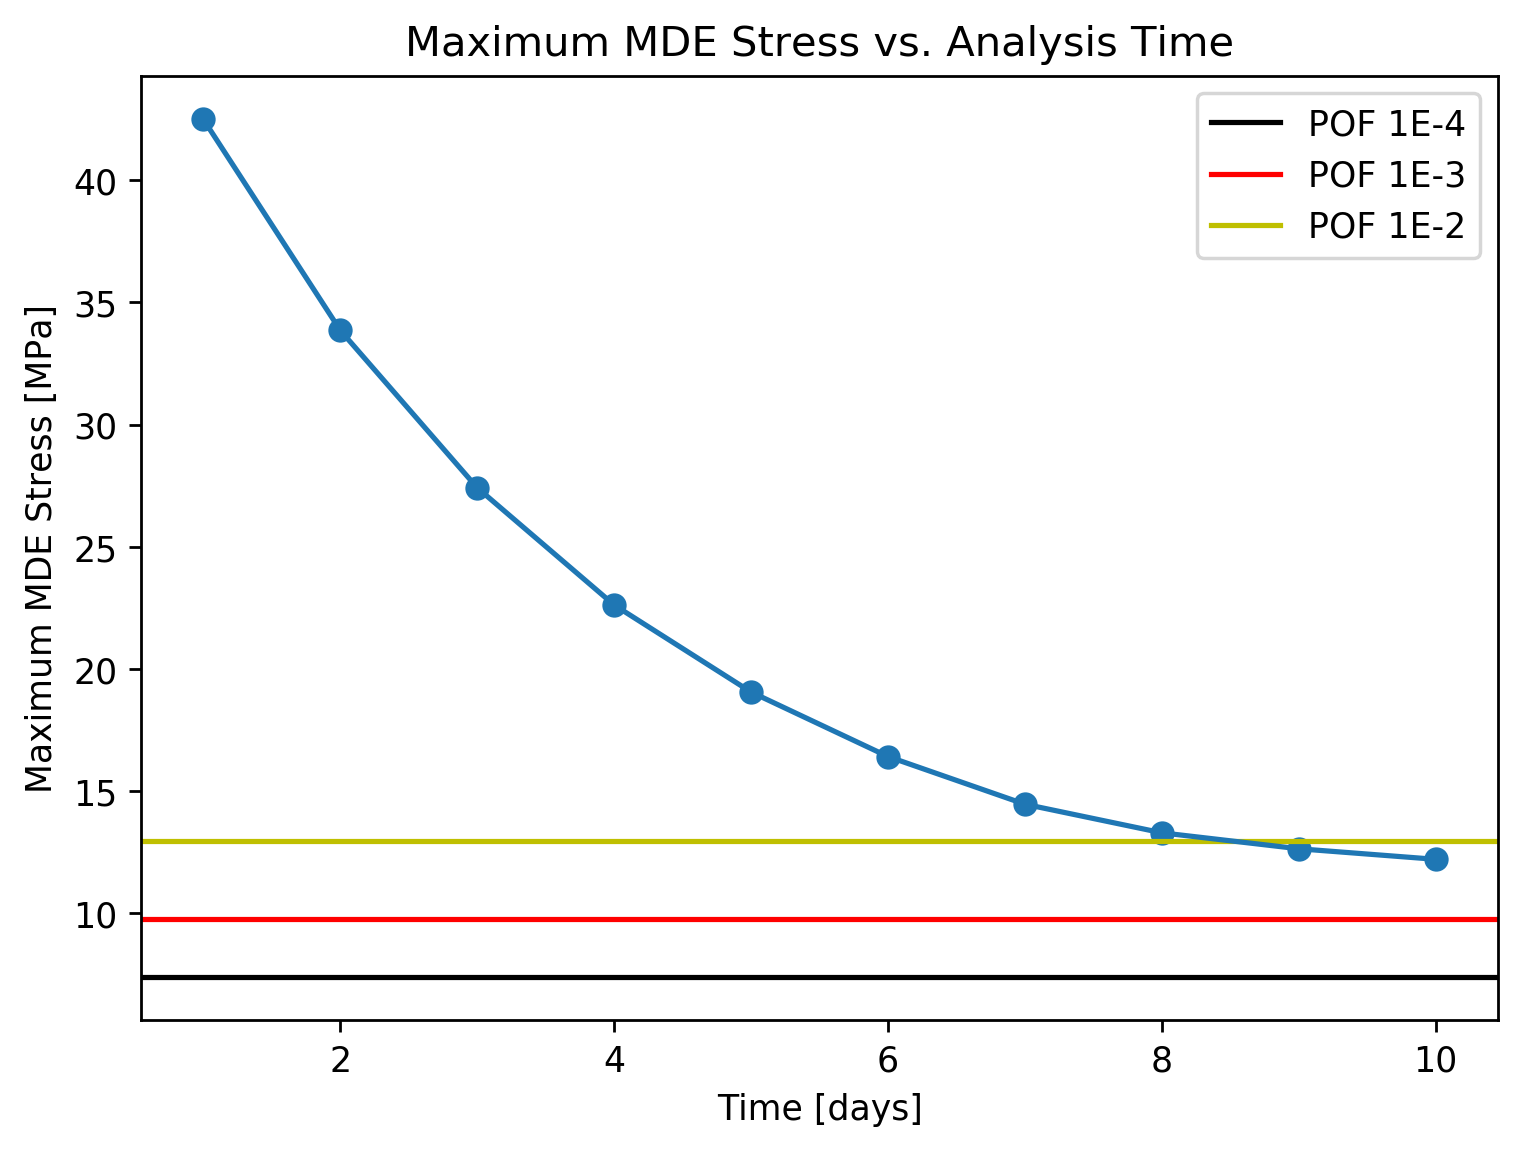

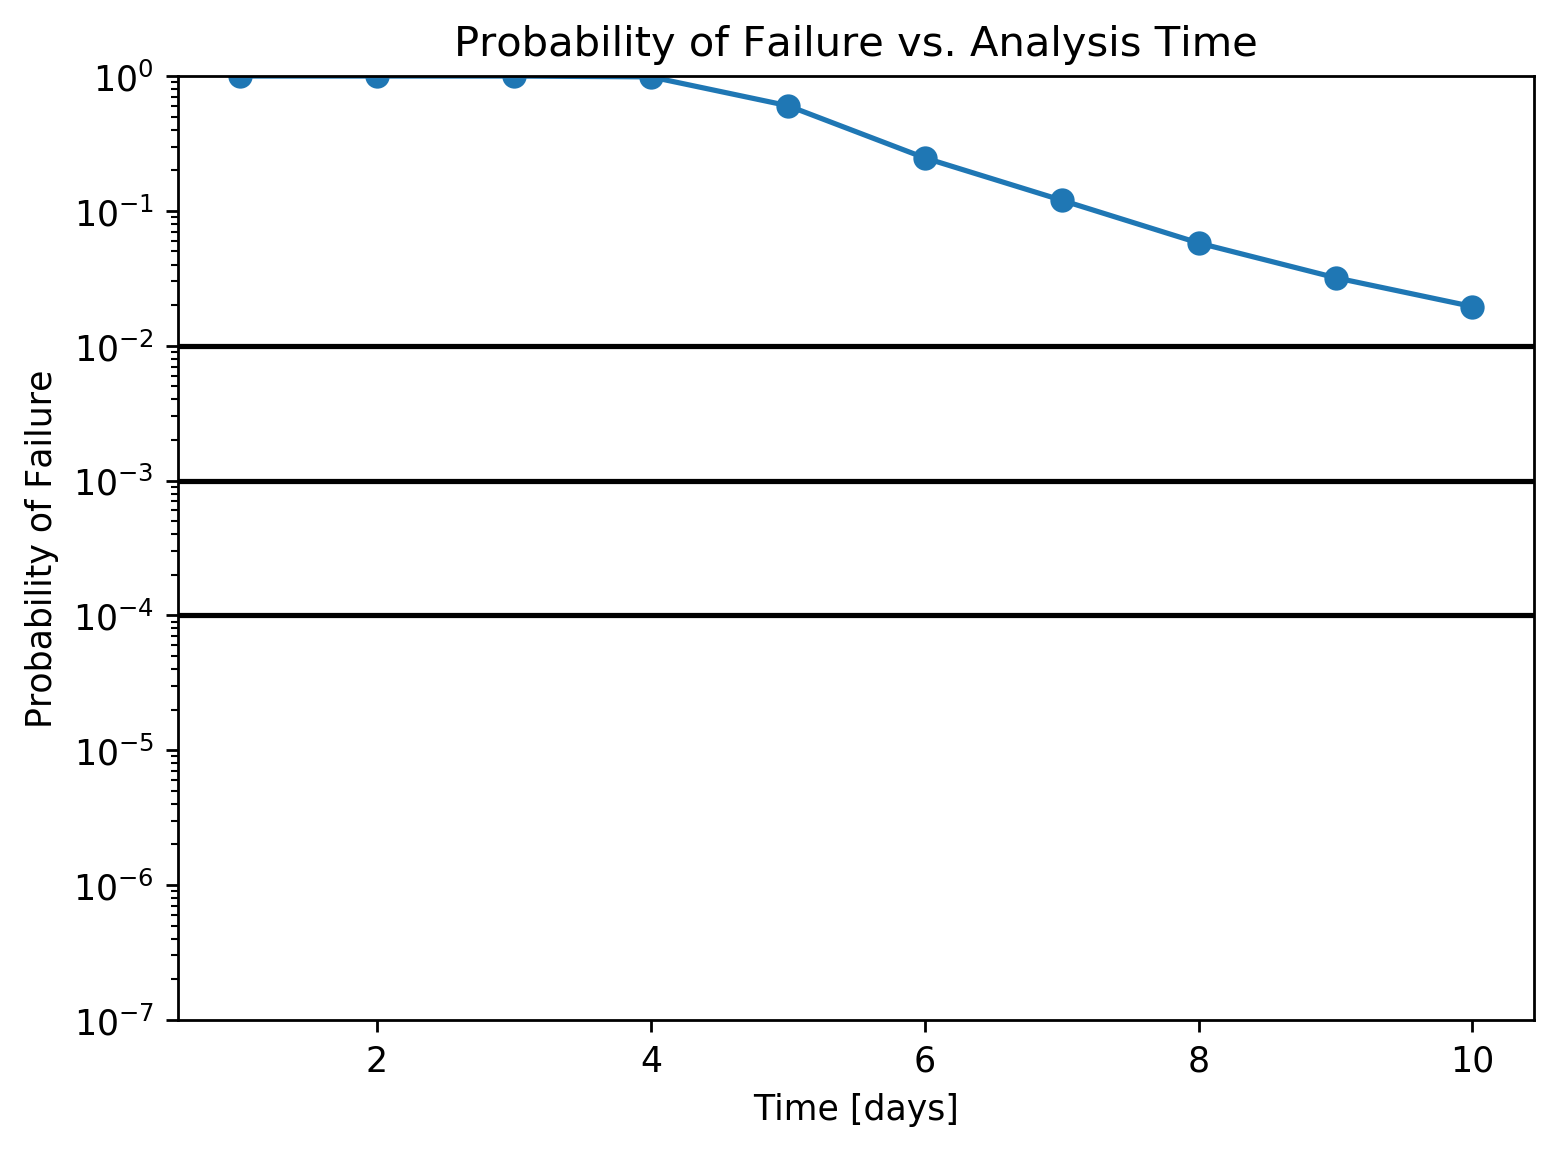

In [5]:
#Graphite type material property fields for GUI
fields = ('Compression to tension conversion ratio', 'Poisson ratio', 'Threshold value S0 [MPa]',
          'Weibull characteristic strength Sc [MPa]', 'Shape Factor m', 'Geometry Scale Factor', 
          'K1C', 'Grain Scaling Factor Alpha', 'Stress Range Threshold Delta','Mean Tensile Stress Sm [MPa]')

fields2 = ('Weibull characteristic strength Sc [MPa]', 'Weibull shape factor m')

#  create variable input deck for standard POF  
def makeform(root, fields):
   entries = {}
   default = ['0.264', '0.15', '8.25', '21.56', '5.78', '1', '1', '10', '0.07','25'] #Default values for GUI fields
   for field in fields:
      row = tk.Frame(root)
      lab = tk.Label(row, width=50, text=field+": ", anchor='w')
      ent = tk.Entry(row)
      ent.insert(0,default[fields.index(str(field))])
      row.pack(side=tk.TOP, fill=tk.X, padx=5, pady=5)
      lab.pack(side=tk.LEFT)
      ent.pack(side=tk.RIGHT, expand=tk.YES, fill = tk.X)
      entries[field] = ent        
   return entries

#  create variable input deck for less conservative POF 
def makeform2(root, fields):
   entries = {}
   default = ['20.49', '9.26']
   for field in fields:
      row = tk.Frame(root)
      lab = tk.Label(row, width=50, text=field+": ", anchor='w')
      ent = tk.Entry(row)
      ent.insert(0,default[fields.index(str(field))])
      row.pack(side=tk.TOP, fill=tk.X, padx=5, pady=5)
      lab.pack(side=tk.LEFT)
      ent.pack(side=tk.RIGHT, expand=tk.YES, fill = tk.X)
      entries[field] = ent        
   return entries

def callback():
    global name
    name = str(fd.askopenfilename())
    selection = "Selcted file = " + str(name)
    print(selection)
    print()
    label1.config(text = selection)
    return(name)

if __name__ == '__main__':
   root = tk.Tk()
   root.title("ASME Section III Division 5 Graphite Life Assessment Tool")
   root.geometry("1200x700")

   intro = tk.Label(root, text="Please ensure all input data is in SI units")
   intro.pack(padx=10, pady=10)
   
   b1 = tk.Button(root, text='File Open', command=callback)
   b1.pack(side = tk.TOP, padx=10, pady=10)
   
   label1 = tk.Label(root)
   label1.pack(side=tk.TOP, padx=5, pady=5)
   
   # Radiobutton for ansys or calculix solver
   v = tk.IntVar()
   tk.Label(root,text="""Choose a Solver:""", justify = tk.LEFT,padx = 20).pack()
   tk.Radiobutton(root, text="ANSYS", padx = 20, variable=v, value=1).pack(anchor = tk.W)
   tk.Radiobutton(root, text="Calculix", padx = 20, variable=v, value=2).pack(anchor = tk.W)
   
   #Description
   descript = tk.Label(root, text="Simplified Assessment")
   descript.pack(padx=10, pady=10)
   
   # bininding simplified assessment input deck to root window
   ents2 = makeform2(root, fields2)
   root.bind("<KeyRelease-Return>", (lambda event, e=ents2: tk.fetch(e))) 
   
   #Description
   descript1 = tk.Label(root, text="Full Assessment")
   descript1.pack(padx=10, pady=10)
   
   # bininding full assessment input deck to root window
   ents = makeform(root, fields)
   root.bind("<KeyRelease-Return>", (lambda event, e=ents: tk.fetch(e))) 
   
   # Buttons for solve POF, File Open or Quit
   b2 = tk.Button(root, text='Probability of Failure', command=(lambda e=ents,e2=ents2: solver_type(v.get(),name,e,e2)))
   b2.pack(side= tk.LEFT, padx=5, pady=5)
   b3 = tk.Button(root, text='Quit', command=root.quit)
   b3.pack(side=tk.LEFT, padx=5, pady=5)
   
   # Printing POF value in textbox

   label = tk.Label(root)
   label.pack(side=tk.LEFT, padx=5, pady=5)
   
   root.mainloop()